# Lab 03: Pitch Classification

---
author: Daniel Yao
date: September 20, 2024
embed-resources: true
---

## Introduction

The purpose of this report is to automatically display the pitch type for each pitch in real-time for the stadium and television broadcasts. This will involve creating a classification model to classify the type of pitch thrown based off ball statistics like velocity and rotation. The data revolves around historical pitching data taken from Statcast. The data will include speed of ball, spin rate, horizontal movement of the pitch, vertical movement of the pitch, side of the plate batter, and type of pitch.

## Methods

In [21]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

### Data

In [22]:
# load data
pitches_train = pd.read_parquet(
    "https://cs307.org/lab-03/data/pitches-train.parquet"
)
pitches_test = pd.read_parquet(
    "https://cs307.org/lab-03/data/pitches-test.parquet"
)
pitches_train


,pitch_name,release_speed,release_spin_rate,pfx_x,pfx_z,stand
0,Sweeper,84.7,2667.0,1.25,0.01,R
1,Sweeper,83.9,2634.0,1.41,0.20,R
2,Sweeper,84.4,2526.0,1.26,0.25,R
3,Curveball,74.3,2389.0,0.93,-1.10,L
4,Sweeper,85.6,2474.0,1.08,0.52,R
...,...,...,...,...,...,...
2623,Split-Finger,91.8,1314.0,-0.30,0.08,R
2624,Sweeper,86.9,2440.0,1.11,0.51,R
2625,4-Seam Fastball,99.2,2320.0,0.04,0.81,R
2626,4-Seam Fastball,97.9,2164.0,0.08,1.06,R


In [23]:
pitches_train.dtypes

pitch_name            object
release_speed        float64
release_spin_rate    float64
pfx_x                float64
pfx_z                float64
stand                 object
dtype: object

In [24]:
# create X and y for train
X_train = pitches_train.drop("pitch_name", axis=1)
y_train = pitches_train["pitch_name"]

# create X and y for test
X_test = pitches_test.drop("pitch_name", axis=1)
y_test = pitches_test["pitch_name"]

In [25]:
# summary statistics
pitches_train['pitch_name'].value_counts()

pitch_name
Sweeper            983
4-Seam Fastball    718
Split-Finger       312
Cutter             233
Curveball          222
Sinker              97
Slider              63
Name: count, dtype: int64

In [26]:
pitches_train['release_speed'].groupby(pitches_train['pitch_name']).describe()

,count,mean,std,min,25%,50%,75%,max
pitch_name,,,,,,,,
4-Seam Fastball,718.0,97.270613,1.699270,90.2,96.200,97.40,98.500,101.4
Curveball,222.0,77.679730,3.215206,68.4,75.425,77.70,80.000,85.2
Cutter,233.0,90.742060,2.364489,82.0,89.500,90.80,92.300,97.1
Sinker,97.0,97.160825,1.829592,92.3,95.900,97.10,98.400,101.1
Slider,63.0,85.203175,2.401543,80.5,83.250,85.60,87.100,90.5
Split-Finger,312.0,89.291346,1.759299,84.4,88.200,89.35,90.325,96.7
Sweeper,983.0,85.336419,1.862552,79.4,84.100,85.40,86.550,90.4


In [27]:
pitches_train['release_spin_rate'].groupby(pitches_train['pitch_name']).describe()

,count,mean,std,min,25%,50%,75%,max
pitch_name,,,,,,,,
4-Seam Fastball,714.0,2217.331933,114.754683,1845.0,2147.00,2215.0,2297.00,2744.0
Curveball,222.0,2482.666667,119.854726,2193.0,2403.25,2492.5,2567.75,2767.0
Cutter,233.0,2378.424893,206.685887,842.0,2350.00,2407.0,2467.00,2667.0
Sinker,95.0,1972.747368,143.920632,1701.0,1900.50,1962.0,2032.00,2979.0
Slider,63.0,2497.619048,78.679306,2341.0,2451.00,2500.0,2550.50,2668.0
Split-Finger,312.0,1273.560897,221.291146,881.0,1140.50,1248.5,1368.00,2617.0
Sweeper,983.0,2492.172940,103.176892,2126.0,2430.50,2498.0,2564.50,2782.0


C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

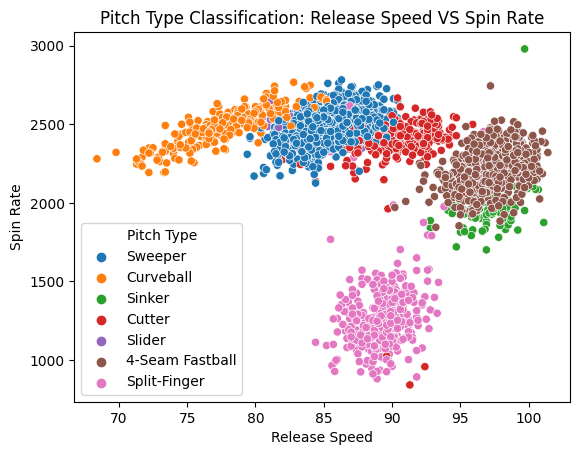

In [28]:
# visualizations
scatter_plot = sns.scatterplot(data=pitches_train, x='release_speed', y='release_spin_rate', hue='pitch_name')
plt.xlabel('Release Speed')
plt.ylabel('Spin Rate')
plt.title('Pitch Type Classification: Release Speed VS Spin Rate')
plt.legend(title='Pitch Type')
plt.show()

Firstly, the training and testing datasets are seperated to ensure the target variable (pitch type) is not mixed with features that will be used for prediction, allowing the model to learn how the features relate to the target variable. Furthermore, the graph shows the classification of different pitch types based off release speed and spin rate. The graph makes it helpful in identifying pitch types depnding on the two features and seeing how they relate to the target variable. 

### Models

In [29]:
# process data for ML
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('onehot', OneHotEncoder(handle_unknown='ignore'))     
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', KNeighborsClassifier())
])

param_grid = {
    'model__n_neighbors': [5, 7, 9, 11, 13],  
}


mod = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
mod.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['release_speed', 'release_spin_rate', 'pfx_x', 'pfx_z'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['stand'], dtype='object'))])),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__n_neighbors': [5, 7, 9, 11, 13]},
             scoring='accuracy')

In [30]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier())
])

param_grid = {
    'model__n_estimators': [100, 200, 300],     
    'model__max_depth': [10, 20, 30, None],       
}


mod1 = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
mod1.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['release_speed', 'release_spin_rate', 'pfx_x', 'pfx_z'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['stand'], dtype='object'))])),
                                       ('model', RandomForestClassifier())]),
             param_grid={'model__max_depth': [10, 20, 30, None],
                         'model__n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [31]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeClassifier())
])

param_grid = {
    'model__max_depth': [10, 20, 30, None],       
}


mod2 = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
mod2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['release_speed', 'release_spin_rate', 'pfx_x', 'pfx_z'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['stand'], dtype='object'))])),
                                       ('model', DecisionTreeClassifier())]),
             param_grid={'model__max_depth': [10, 20, 30, None]},
             scoring='accuracy')

In [32]:
# train models
y_pred_train = mod.predict(X_train)
y_pred_test = mod.predict(X_test)

In [33]:
y_pred_train_Random = mod1.predict(X_train)
y_pred_test_Random = mod1.predict(X_test)

In [34]:
y_pred_train_Decision = mod2.predict(X_train)
y_pred_test_Decision = mod2.predict(X_test)

3 different classification model is used to determine the most accurate classifer - KNN, random forest, and decision tree. To optimize the model performance, hyperparameters like the number of neighbors of the KNN is fine-tuned to find the number with the highest accuracy. Most parameters are kept the same between the different classification models to maintain a fair comparison and obtain the highest accuracy.

## Results

In [35]:
# report model metrics
train_accuracy = accuracy_score(y_train, y_pred_train)
print("KNN Training Accuracy:", train_accuracy)

test_accuracy = accuracy_score(y_test, y_pred_test)
print("KNN Testing Accuracy:", test_accuracy)

KNN Training Accuracy: 0.9798325722983258
KNN Testing Accuracy: 0.9388888888888889


In [36]:
train_accuracy = accuracy_score(y_train, y_pred_train_Random)
print("Random Forest Training Accuracy:", train_accuracy)

test_accuracy = accuracy_score(y_test, y_pred_test_Random)
print("Random Forest Testing Accuracy:", test_accuracy)

Random Forest Training Accuracy: 1.0
Random Forest Testing Accuracy: 0.9191358024691358


In [40]:
train_accuracy = accuracy_score(y_train, y_pred_train_Decision)
print("Decision Tree Training Accuracy:", train_accuracy)

test_accuracy = accuracy_score(y_test, y_pred_test_Decision)
print("Decision Tree Testing Accuracy:", test_accuracy)

Decision Tree Training Accuracy: 1.0
Decision Tree Testing Accuracy: 0.8975308641975308


In [39]:
from joblib import dump
dump(mod, "pitch-classifier.joblib")

['pitch-classifier.joblib']

The KNN model is able to get high accuracy on both testing with 98.0% and training with 93.9%. This high accuracy shows that the model is able to classify pitch types accurately on both testing and training datasets. The report also confirms this by having a high weighted average for both test and train data. Although all the models have good accuracy, KNN has the highest accuracy especially in terms of testing accuracy. Decision tree and Random Forest show a high training accuracy of 100%; however they have lower testing accuracy. This is a clear case of overfitting where it does not generalize well to unseen test data.

## Discussion

In conclusion, the KNN model is the best case for classifying different pitch types. It does not overfit and generalize well to the unseen data compared to decision tree and random forest classification models. Having the highest accuracy of 93.9% in testing accuracy, indicating a good balance of fitting training and testing data. Although the model has a high accuracy, I would not consider employing the model. There are too many factors in consideration that is left out from the dataset. There are numerous pitchers in the MLB with their own throwing style that will vasely differ from each other. The dataset only consider one pitcher and data from him will not apply to everyone. The model may have a high accuracy, but it can only confidently identify pitches thrown from Shohei Ohtani and not other pitchers. Pitchers can also learn new pitches or adapt new ones on the fly. The dataset will need to be updated constantly with new data and include data from other pitchers to make it viable in the MLB. 